#**Install Library**

In [1]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet

# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet

Reading package lists...
Building dependency tree...
Reading state information...
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6 python3-rtree
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 365 kB of archives.
After this operation, 1,799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/unive

In [2]:
!pip install esda

In [3]:
!pip install contextily

#**Import Library**

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pysal
from pysal.lib  import weights
from pysal.explore import  esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster


/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


#**Load Dataset**

In [25]:
#from dropbox
#!wget https://www.dropbox.com/s/faadrrss/california.geojson

import geopandas as gpd

# Load GeoJSON data
COUNTY_NAME = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/ir.json"
COUNTY_NAME = gpd.read_file(COUNTY_NAME)

# Display the first few rows of the GeoDataFrame
COUNTY_NAME.head(10)


,source,id,name,geometry
0,https://simplemaps.com,IR02,West Azarbaijan,"POLYGON ((45.49453 38.98192, 45.48821 38.97690..."
1,https://simplemaps.com,IR01,East Azarbaijan,"POLYGON ((47.19384 36.75683, 46.95644 36.73476..."
2,https://simplemaps.com,IR03,Ardebil,"POLYGON ((48.45526 37.22388, 48.44152 37.22781..."
3,https://simplemaps.com,IR19,Gilan,"POLYGON ((48.88253 37.20279, 48.87157 37.22739..."
4,https://simplemaps.com,IR16,Kordestan,"POLYGON ((45.50142 36.00543, 45.50196 36.00597..."
5,https://simplemaps.com,IR17,Kermanshah,"POLYGON ((46.12529 35.28499, 46.15298 35.27738..."
6,https://simplemaps.com,IR05,Ilam,"POLYGON ((45.72463 33.63304, 45.74732 33.64885..."
7,https://simplemaps.com,IR10,Khuzestan,"POLYGON ((47.58023 32.10350, 47.60705 32.11256..."
8,https://simplemaps.com,IR31,North Khorasan,"POLYGON ((57.73483 37.89827, 57.61357 37.83914..."
9,https://simplemaps.com,IR27,Golestan,"POLYGON ((56.16674 38.08079, 56.17345 38.01070..."


# **Get Longitude dan Latitude**

In [26]:
import geopandas as gpd

# Load GeoJSON data
COUNTY_NAME = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/ir.json"
iran_map = gpd.read_file(COUNTY_NAME)

# Konversi CRS geometri ke EPSG:4326
iran_map = iran_map.to_crs(epsg=4326)

# Konversi geometri ke CRS yang sesuai sebelum mengambil titik tengah
iran_map = iran_map.to_crs("+proj=aea +lat_1=37.5 +lat_2=39.5 +lat_0=38.5 +lon_0=47.5 +x_0=4000000 +y_0=3000000 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")

# Ambil titik tengah geometri sebagai longitude dan latitude
iran_map['longitude'] = iran_map['geometry'].centroid.x
iran_map['latitude'] = iran_map['geometry'].centroid.y

# Tampilkan DataFrame
#print(iran_map[['VARNAME_1', 'longitude', 'latitude']].head())

# Tampilkan DataFrame
iran_map[['name', 'longitude','latitude','geometry']].head()


,name,longitude,latitude,geometry
0,West Azarbaijan,3.803546e+06,2.915228e+06,"POLYGON ((3826263.164 3055397.919, 3825703.725..."
1,East Azarbaijan,3.918028e+06,2.935994e+06,"POLYGON ((3972653.729 2806571.746, 3951434.493..."
2,Ardebil,4.037098e+06,3.001865e+06,"POLYGON ((4084786.206 2858788.428, 4083561.745..."
3,Gilan,4.174159e+06,2.866259e+06,"POLYGON ((4122741.205 2856930.515, 4121727.983..."
4,Kordestan,3.950785e+06,2.691457e+06,"POLYGON ((3819689.428 2725148.152, 3819738.803..."


# **Create Boundaries Iran Map**

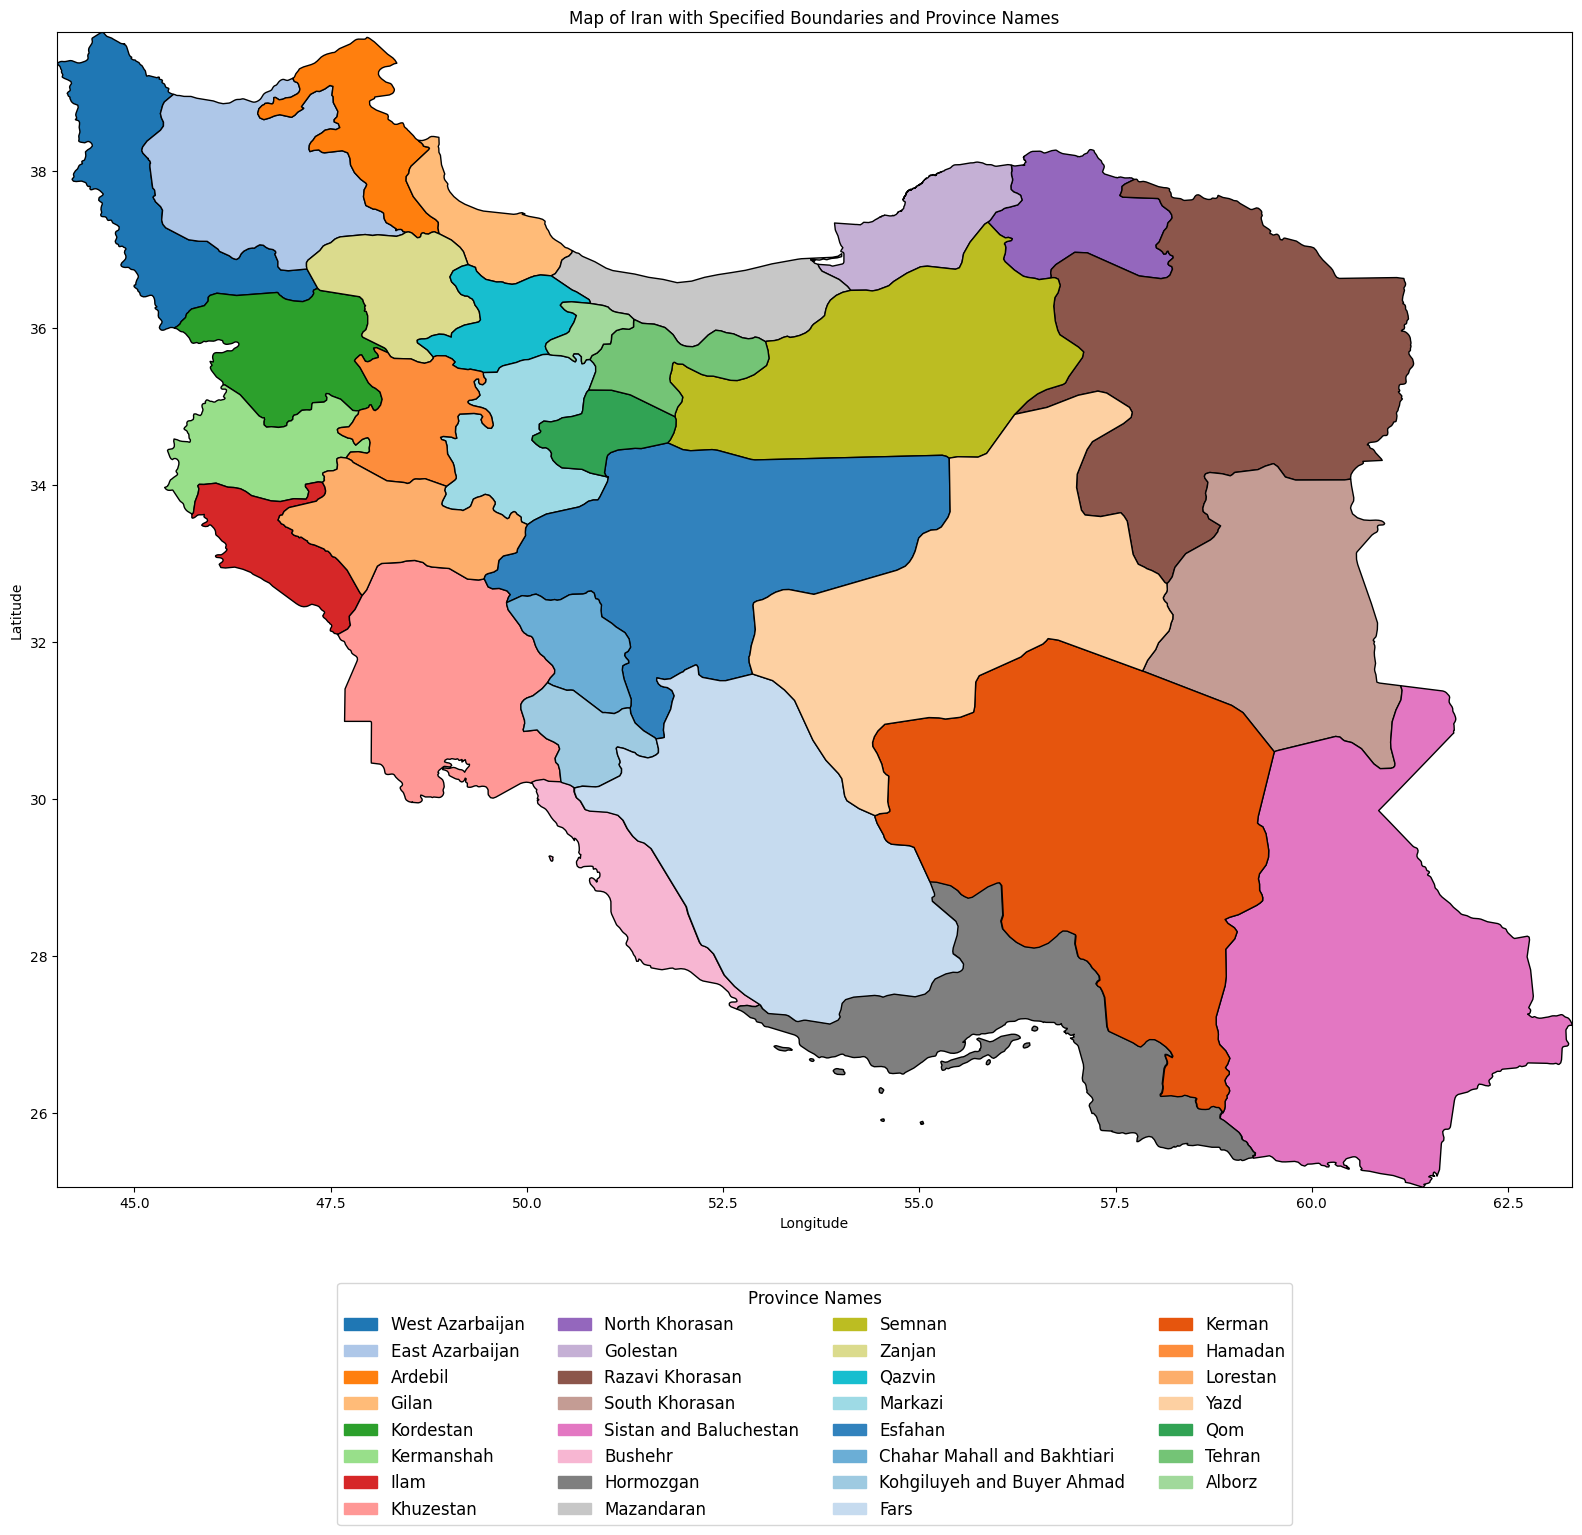

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors

# Load GeoJSON data
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/ir.json"
iran_map = gpd.read_file(geojson_url)

# Get unique province names and count
province_names = iran_map['name'].unique()
num_provinces = len(province_names)

# Generate a colormap with a unique color for each province name
cmap = colors.ListedColormap(cm.tab20.colors + cm.tab20c.colors + cm.tab20b.colors, name='tab60')
colors = cmap(range(num_provinces))
province_color_map = {name: color for name, color in zip(province_names, colors)}

# Plot the map
fig, ax = plt.subplots(figsize=(20, 15))

# Plot each province with a different color
for name in province_names:
    province_data = iran_map[iran_map['name'] == name]
    province_data.plot(ax=ax, color=province_color_map[name], edgecolor='black', label=name, aspect='equal')

# Set the limits for longitude and latitude
min_lat, min_lon = iran_map.total_bounds[1], iran_map.total_bounds[0]
max_lat, max_lon = iran_map.total_bounds[3], iran_map.total_bounds[2]
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Create legend patches and labels
legend_patches = [Patch(color=province_color_map[name], label=name) for name in province_names]

# Add legend outside the plot with 4 columns
ax.legend(handles=legend_patches, title='Province Names', title_fontsize='large', fontsize='large', loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=4)

# Add labels and title
plt.title('Map of Iran with Specified Boundaries and Province Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


# **Load Earthquake Dataset**

In [32]:
# importing libraries
import pandas as pd # Reading csv file
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame

# Baca dataset
dataset1 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1972-1987.csv"
dataset2 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1988-1998.csv"
dataset3 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1999-2019.csv"
dataset4 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran2020-2022.csv"
# Load each dataset
df1 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1972-1987.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1988-1998.csv")
df3 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1999-2019.csv")
df4 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran2020-2022.csv")

# Concatenate the datasets
merged_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# creating a geometry column
geometry = [Point(xy) for xy in zip(merged_df['longitude'], merged_df['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame
gdf = gpd.GeoDataFrame(merged_df, crs=crs, geometry=geometry)

gdf.head(10)

df=gdf

# Konversi kolom 'time' ke format datetime
merged_df['time'] = pd.to_datetime(merged_df['time'])

# Seleksi data hanya untuk tahun 1968 - 2018
df_selected = merged_df[(merged_df['time'].dt.year >= 1968) & (merged_df['time'].dt.year <= 2018)].copy()

# Memperbarui kolom 'city' dengan menggunakan .loc
df_selected['city'] = df_selected['place'].str.split(',').str[0].str.split('of').str[-1].str.strip()

df_selected['year'] = df_selected['time'].dt.year
# Ubah format kolom 'time' menjadi YYYY-MM-DD
df_selected['time'] = df_selected['time'].dt.strftime('%Y-%m-%d')


# Mengambil hanya kolom yang diinginkan
df_selected = df_selected[['time','year' , 'latitude', 'longitude', 'place', 'city','depth', 'mag', 'magType','geometry']]
df_selected.head()

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


KeyError: "['geometry'] not in index"

In [ ]:
# Group by 'city' and count earthquakes in each city
city_earthquake_counts = df_selected.groupby('place').size().reset_index(name='earthquake_count')

# Tampilkan tabel hasil grouping
print(city_earthquake_counts)


In [ ]:
# Group by 'place' and calculate average magnitude in each place
place_avg_magnitude = df_selected.groupby('place')['mag'].mean().reset_index(name='avg_magnitude')

# Merge average magnitude with df_selected based on 'place'
df_moreselected = df_selected.merge(place_avg_magnitude, on='place', how='left')

# Tampilkan tabel hasil
df_moreselected.head()


In [ ]:
import folium
from folium.plugins import FloatImage

# Buat objek peta
m = folium.Map(location=[37, -120], zoom_start=6)  # Koordinat tengah California

# Buat dictionary untuk memetakan rentang magnitude ke warna
color_scale = {
    (0, 3): 'lightgreen',
    (3, 5): 'orange',
    (5, 7): 'red',
    (7, float('inf')): 'darkred'
}

# Tambahkan marker untuk setiap gempa bumi
for idx, row in df_moreselected.iterrows():
    # Tentukan warna berdasarkan nilai rata-rata magnitude
    color = 'blue'  # Default color jika tidak ada nilai rata-rata magnitude
    for mag_range, mag_color in color_scale.items():
        if mag_range[0] <= row['avg_magnitude'] < mag_range[1]:
            color = mag_color
            break

    # Tambahkan marker dengan warna yang sesuai
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=3,
                        color=color,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.6,
                        popup=f"Magnitude: {row['avg_magnitude']:.2f}").add_to(m)

# Buat legenda
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 150px; height: 180px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 opacity: 0.8;
                 ">
     <p style="margin-top: 5px; margin-left: 5px;">Legend</p>
     <p style="margin-left: 10px; font-size: 16px; color: lightgreen;">0-3</p>
     <p style="margin-left: 10px; font-size: 16px; color: orange;">3-5</p>
     <p style="margin-left: 10px; font-size: 16px; color: red;">5-7</p>
     <p style="margin-left: 10px; font-size: 16px; color: darkred;">7+</p>
      </div>
     '''

# Tambahkan legenda ke peta
m.get_root().html.add_child(folium.Element(legend_html))

# Tampilkan peta
m


# **Spatial distribution**

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

# Baca GeoDataFrame dari URL GeoJSON
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/California_County_Boundaries.geojson"
gdf_boundary = gpd.read_file(geojson_url)

# Baca dataset
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
df = pd.read_csv(dataset_url)

# Membuat geometry column
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Membuat Geographic DataFrame
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Konversi kolom 'time' ke format datetime
gdf['time'] = pd.to_datetime(gdf['time'])

# Seleksi data hanya untuk tahun 1968 - 2018
gdf_selected = gdf[(gdf['time'].dt.year >= 1968) & (gdf['time'].dt.year <= 2018)].copy()

# Memperbarui kolom 'city'
gdf_selected['city'] = gdf_selected['place'].str.split(',').str[0].str.split('of').str[-1].str.strip()

# Ubah format kolom 'time' menjadi YYYY-MM-DD
gdf_selected['time'] = gdf_selected['time'].dt.strftime('%Y-%m-%d')

# Mengambil hanya kolom yang diinginkan
gdf_selected = gdf_selected[['time', 'latitude', 'longitude', 'place', 'city', 'depth', 'mag', 'magType', 'geometry']]

# Menentukan warna dan skema pengisian
cmap = "Reds"  # Palet warna
column = "mag"  # Kolom untuk pengisian
scheme = "quantiles"  # Skema pengisian (quantiles)

# Membuat peta menggunakan matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data gdf_selected
gdf_selected.plot(column=column, cmap=cmap, scheme=scheme, legend=True, ax=ax)

# Plotting batas menggunakan gdf_boundary
gdf_boundary.boundary.plot(ax=ax, color='black', alpha=0.4)

# Menambahkan judul
plt.title("Magnitude Distribution in California (1968-2018)")

# Menampilkan peta
plt.show()


# **Statistics**

In [ ]:
# Define the magnitude ranges
mag_ranges = [(2, 3.9), (4, 4.9), (5, 5.9), (6, 9.9)]

# Initialize an empty list to store the statistics
statistics = []

# Calculate statistics for each magnitude range
for mag_range in mag_ranges:
    min_mag, max_mag = mag_range
    subset = df_selected[(df_selected['mag'] >= min_mag) & (df_selected['mag'] <= max_mag)]
    total = len(subset)
    percentage = (total / len(df_selected)) * 100
    min_magnitude = subset['mag'].min()
    max_magnitude = subset['mag'].max()
    mean_magnitude = subset['mag'].mean()
    sd_magnitude = subset['mag'].std()
    statistics.append({
        'Magnitude Earthquake': f"{min_mag}≤M≤{max_mag}",
        'Total': total,
        '% earthquake': percentage,
        'Minimum Magnitude': min_magnitude,
        'Maximum Magnitude': max_magnitude,
        'Mean Magnitude': mean_magnitude,
        'SD Magnitude': sd_magnitude
    })

# Create a DataFrame from the statistics
statistics_df = pd.DataFrame(statistics)

# Print the statistics table
print("Table 1. Statistic table of earthquakes")
statistics_df

# **Global Spatial Autocorrelation**

In [ ]:
import pandas as pd
from libpysal import weights
from esda.moran import Moran

# Baca dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
df = pd.read_csv(dataset)

# Buat geometri kolom menggunakan longitude dan latitude
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Bangun matriks spatialis
w = weights.KNN.from_dataframe(df, k=1)

# Periksa apakah matriks bobot terhubung sepenuhnya
if not w.islands:
    print("Matriks bobot terhubung sepenuhnya.")
else:
    print("Matriks bobot tidak sepenuhnya terhubung. Ada komponen yang tidak terhubung.")

# Hitung Moran's I
moran = Moran(df['mag'], w)

# Print Moran's I
print("Moran's I:", moran.I)
print("P-value:", moran.p_sim)


In [ ]:
from splot.esda import moran_scatterplot

# Buat Moran Scatter plot
fig, ax = moran_scatterplot(moran, zstandard=True)
plt.show()


In [ ]:
import pandas as pd
from libpysal import weights
from esda.moran import Moran
from shapely.geometry import Point

# Baca dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
df = pd.read_csv(dataset)

# Buat kolom geometri menggunakan longitude dan latitude
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Bangun matriks spatialis untuk seluruh data
w = weights.KNN.from_dataframe(df, k=1)

# Periksa apakah matriks bobot terhubung sepenuhnya
if not w.islands:
    print("Matriks bobot terhubung sepenuhnya.")
else:
    print("Matriks bobot tidak sepenuhnya terhubung. Ada komponen yang tidak terhubung.")

# Mendefinisikan fungsi untuk menghitung Moran's I berdasarkan rentang magnitude
def calculate_moran_i(df, mag_range):
    df_subset = df[(df['mag'] >= mag_range[0]) & (df['mag'] < mag_range[1])]
    # Periksa apakah ada observasi di subset data
    if len(df_subset) > 0:
        w_subset = weights.KNN.from_dataframe(df_subset, k=1)
        moran_subset = Moran(df_subset['mag'], w_subset)
        return moran_subset
    else:
        return None

# Hitung Moran's I untuk setiap rentang magnitude
magnitude_ranges = [(2, 3.9), (4, 4.9), (5, 5.9), (6, 9.9), (2, 9.9)]
moran_results = {}
for mag_range in magnitude_ranges:
    moran_result = calculate_moran_i(df, mag_range)
    if moran_result:
        moran_results[mag_range] = moran_result

# Buat dataframe dari hasil analisis Moran's I
data = []
for mag_range, moran_result in moran_results.items():
    # Tentukan Pattern Type berdasarkan p-value
    pattern_type = "Random" if moran_result.p_sim >= 0.05 else "Clustered"
    data.append({
        'Magnitude Range': f"{mag_range[0]}≤M<{mag_range[1]}",
        "Moran's I": moran_result.I,
        'P-value': moran_result.p_sim,
        'Z Statistic': moran_result.z_sim,
        'Pattern Type': pattern_type
    })

df_result = pd.DataFrame(data)

# Tampilkan dataframe
df_result


# **Analysis Result of Average Nearest Neighbor**

In [ ]:
from pysal.lib import weights
from esda import Moran_Local

# Define the magnitude ranges
mag_ranges = [(2, 3.9), (4, 4.9), (5, 5.9), (6, 9.9)]

# Initialize an empty list to store the analysis results
analysis_results = []

# Calculate Average Nearest Neighbor (ANN) for each magnitude range
for min_mag, max_mag in mag_ranges:
    subset = df_selected[(df_selected['mag'] >= min_mag) & (df_selected['mag'] <= max_mag)]
    try:
        w = weights.KNN.from_dataframe(subset, k=1)
        local_moran = Moran_Local(subset['mag'], w)
        avg_nearest_neighbor = local_moran.Is.mean()
        z_statistic = local_moran.z.mean()
        p_value = local_moran.p_sim.mean()
        pattern_type = "Clustered" if (z_statistic < 0) else "Dispersed"
    except ValueError:
        avg_nearest_neighbor = 0
        z_statistic = 0
        p_value = 1
        pattern_type = "Insufficient neighbors"
    analysis_results.append({
        'Magnitude': f"{min_mag}≤M≤{max_mag}",
        'Average Nearest Neighbor': avg_nearest_neighbor,
        'Z Statistic': z_statistic,
        'P value': p_value,
        'Pattern type': pattern_type
    })

# Create a DataFrame from the analysis results
analysis_results_df = pd.DataFrame(analysis_results)

# Print the analysis results table
print("Table 2. Analysis Result of Average Nearest Neighbor")
analysis_results_df


# **Analysis result of Getis-Ord general**



In [ ]:
import pandas as pd
from libpysal import weights
from esda.getisord import G_Local
from shapely.geometry import Point

# Baca dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
df = pd.read_csv(dataset)

# Buat kolom geometri menggunakan longitude dan latitude
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Mendefinisikan fungsi untuk menghitung Getis-Ord General Index berdasarkan rentang magnitude
def calculate_getisord_index(df, mag_range):
    df_subset = df[(df['mag'] >= mag_range[0]) & (df['mag'] <= mag_range[1])]
    # Periksa apakah ada data dalam subset
    if df_subset.shape[0] > 0:  # Gunakan 'shape[0]' untuk mendapatkan jumlah baris DataFrame
        # Bangun matriks spatialis untuk subset data
        w_subset = weights.KNN.from_dataframe(df_subset, k=1)
        # Hitung Getis-Ord General Index
        glocal = G_Local(df_subset['mag'], w_subset)
        return glocal
    else:
        print(f"No data found for magnitude range {mag_range}")
        return None

# Hitung Getis-Ord General Index untuk setiap rentang magnitude
magnitude_ranges = [(2, 3.9), (4, 4.9), (5, 5.9), (6, 9.9), (2, 9.9)]
getisord_results = {}
for mag_range in magnitude_ranges:
    getisord_result = calculate_getisord_index(df, mag_range)
    if getisord_result is not None:  # Periksa jika hasilnya tidak None
        getisord_results[mag_range] = getisord_result

# Buat dataframe dari hasil analisis Getis-Ord General Index
data = []
for mag_range, getisord_result in getisord_results.items():
    # Ambil nilai indeks, Z Statistic, dan p-value untuk setiap baris yang Highly Clustered
    for i in range(len(getisord_result.z_sim)):
        if getisord_result.p_sim[i] < 0.05:  # Filter hanya untuk Highly Clustered
            data.append({
                'Magnitude Range': f"{mag_range[0]}≤M≤{mag_range[1]}",
                'Getis-Ord General Index': getisord_result.Gs[i],
                'Index Z Statistic': getisord_result.z_sim[i],
                'P-value': getisord_result.p_sim[i],
                'Pattern Type': "Highly Clustered"
            })

df_result = pd.DataFrame(data)

# Tampilkan dataframe
print("Table of Analysis result of Getis-Ord General")
df_result

# **KDE**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definisikan rentang magnitudo
magnitude_ranges = [(2, 3.9), (4, 4.9), (5, 5.9), (6, 9.9), (2, 9.9)]

# Hitung jumlah baris dan kolom yang dibutuhkan
num_rows = (len(magnitude_ranges) + 1) // 2
num_cols = 2

# Buat subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 6*num_rows))

# Iterasi melalui rentang magnitudo dan plot di setiap subplot
for i, mag_range in enumerate(magnitude_ranges):
    # Filter data berdasarkan rentang magnitudo
    df_subset = df[(df['mag'] >= mag_range[0]) & (df['mag'] <= mag_range[1])]

    # Hitung indeks subplot
    row = i // 2
    col = i % 2

    # Plot KDE pada subplot yang sesuai
    kde = sns.kdeplot(x=df_subset['longitude'], y=df_subset['latitude'], cmap='viridis', fill=True, bw_adjust=0.1, ax=axes[row, col])

    # Atur judul subplot
    axes[row, col].set_title(f'Magnitude Range {mag_range[0]}≤M≤{mag_range[1]}')
    axes[row, col].set_xlabel('Longitude')
    axes[row, col].set_ylabel('Latitude')

    # Tambahkan legenda hanya jika plot KDE berhasil dibuat
    if kde.collections:
        cb = fig.colorbar(kde.collections[0], ax=axes[row, col], orientation='horizontal', aspect=40)
        cb.set_label('Density Level')

# Atur layout subplot
plt.tight_layout()

# Tampilkan plot
plt.show()


# **Local Autocorrelation**

In [ ]:
from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt

# Menghilangkan nilai yang hilang
df = df.dropna(subset=['mag'])

# Membuat matriks bobot spasial
w = weights.KNN.from_dataframe(df, k=1)

# Menghitung Moran's I
y_mag = df['mag']
moran = Moran(y_mag, w)

# Mencetak hasil Moran's I
print("Moran's I:", moran.I)

# Local Moran's I
mag_local_moran = esda.moran.Moran_Local(y_mag, w)

# Plotting Local Moran's I scatterplot
plt.figure(figsize=(10, 8))  # Atur ukuran plot di sini
moran_scatterplot(mag_local_moran, p=0.05)

plt.ylim(-0.25, 4)


# Tambahkan keterangan
plt.text(1.95, 1, 'HH', fontsize=15)
plt.text(1.95, -1.0, 'HL', fontsize=15)
plt.text(-1.5, 1, 'LH', fontsize=15)
plt.text(-1.5, -1, 'LL', fontsize=15)

plt.show()


In [ ]:
import geopandas as gpd
from splot.esda import lisa_cluster

# Ubah DataFrame menjadi GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Plotting Local Moran's I scatterplot
fig, ax = lisa_cluster(local_moran, gdf, p=0.05, figsize=(10, 8))
plt.show()
